In [1]:
import scanpy as sc
import GmGM
import matplotlib.pyplot as plt
import matplotlib.patches as mpatches
import numpy as np
from scipy.sparse import csgraph
from scipy import sparse
import igraph as ig
import anndata as ad
import random

from sklearn.covariance import graphical_lasso as glasso
from sklearn import metrics
from sklearn.preprocessing import StandardScaler

import itertools
from typing import Optional, Literal

from mean_wrapper import NoncentralKS
from strong_product_model import strong_product_model

plt.style.use('tableau-colorblind10')

/usr/local/python/3.12.1/lib/python3.12/site-packages/anndata/utils.py:434: FutureWarning: Importing read_csv from `anndata` is deprecated. Import anndata.io.read_csv instead.
  warnings.warn(msg, FutureWarning)
/usr/local/python/3.12.1/lib/python3.12/site-packages/anndata/utils.py:434: FutureWarning: Importing read_excel from `anndata` is deprecated. Import anndata.io.read_excel instead.
  warnings.warn(msg, FutureWarning)
/usr/local/python/3.12.1/lib/python3.12/site-packages/anndata/utils.py:434: FutureWarning: Importing read_hdf from `anndata` is deprecated. Import anndata.io.read_hdf instead.
  warnings.warn(msg, FutureWarning)
/usr/local/python/3.12.1/lib/python3.12/site-packages/anndata/utils.py:434: FutureWarning: Importing read_loom from `anndata` is deprecated. Import anndata.io.read_loom instead.
  warnings.warn(msg, FutureWarning)
/usr/local/python/3.12.1/lib/python3.12/site-packages/anndata/utils.py:434: FutureWarning: Importing read_mtx from `anndata` is deprecated. Import

To get familiar with graphical models, we'll first run them on synthetic data.

The synthetic dataset below, "blobs", is a very simple dataset on which we can test
the capacity of our method to cluster cells.  It won't necessarily be indicative of
how methods perform on real data.

AnnData object with n_obs × n_vars = 700 × 11
    obs: 'blobs'

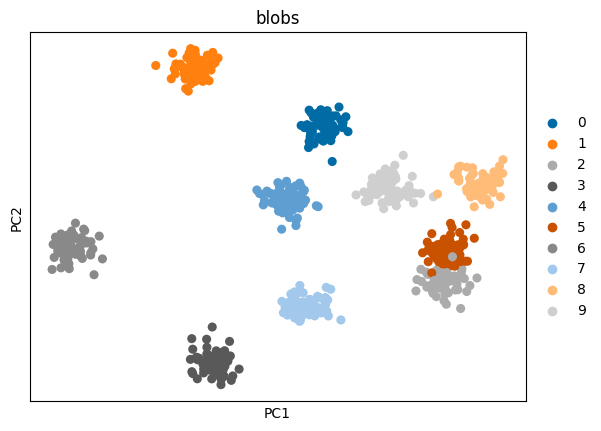

In [2]:
blob_data = sc.datasets.blobs(
    random_state=0,
    n_centers=10,
    n_observations=700,
    n_variables=11
)
display(blob_data)

#sc.pp.log1p(blob_data)
sc.pp.pca(blob_data)
sc.pl.pca(blob_data, color='blobs')

In [3]:
blob_data = GmGM.GmGM(
    blob_data,
    to_keep=0.05,
    min_edges={"obs": 5, "var": 3}, # to ensure the graphs have no singletons
)
print(blob_data.obsp['obs_gmgm_connectivities'])
blob_data

/usr/local/python/3.12.1/lib/python3.12/site-packages/GmGM/GmGM.py:231: UserWarning: This is outdated, will swap to using direct_left_eigenvectors in the future
  warnings.warn("This is outdated, will swap to using direct_left_eigenvectors in the future")


<Compressed Sparse Row sparse array of dtype 'float64'
	with 7392 stored elements and shape (700, 700)>
  Coords	Values
  (0, 0)	0.9989140033721924
  (0, 52)	0.0043642777018249035
  (0, 279)	0.0041461726650595665
  (0, 409)	0.004194192588329315
  (0, 534)	0.004302915185689926
  (0, 690)	0.004204769618809223
  (1, 1)	0.9995852112770081
  (1, 9)	0.003675126703456044
  (1, 137)	0.0034698708914220333
  (1, 159)	0.0034083430655300617
  (1, 215)	0.0034296654630452394
  (1, 668)	0.0034457803703844547
  (2, 2)	0.9949819445610046
  (2, 53)	0.008511118590831757
  (2, 182)	0.00843374989926815
  (2, 329)	0.008329211734235287
  (2, 478)	0.008322040550410748
  (2, 537)	0.008297626860439777
  (3, 3)	0.9967525005340576
  (3, 55)	0.006096246186643839
  (3, 194)	0.006175587885081768
  (3, 398)	0.006315808277577162
  (3, 420)	0.006278135348111391
  (3, 575)	0.006033758632838726
  (4, 4)	0.9982010722160339
  :	:
  (696, 629)	0.005116017535328865
  (696, 633)	0.004955108277499676
  (696, 635)	0.00485446862

AnnData object with n_obs × n_vars = 700 × 11
    obs: 'blobs'
    uns: 'pca', 'blobs_colors', 'obs_neighbors_gmgm', 'var_neighbors_gmgm'
    obsm: 'X_pca'
    varm: 'PCs'
    obsp: 'obs_gmgm_connectivities'
    varp: 'var_gmgm_connectivities'

The above code ran GmGM, which generates a graph.  We'll now cluster on this graph.

/tmp/ipykernel_3820/4043669518.py:3: FutureWarning: In the future, the default backend for leiden will be igraph instead of leidenalg.

 To achieve the future defaults please pass: flavor="igraph" and n_iterations=2.  directed must also be False to work with igraph's implementation.
  sc.tl.leiden(blob_data, obsp='obs_gmgm_connectivities', key_added='leiden_gmgm', resolution=0.1)


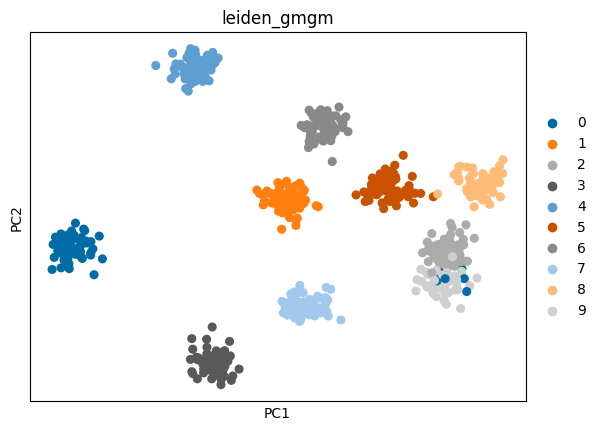

AnnData object with n_obs × n_vars = 700 × 11
    obs: 'blobs', 'leiden_gmgm'
    uns: 'pca', 'blobs_colors', 'obs_neighbors_gmgm', 'var_neighbors_gmgm', 'leiden_gmgm', 'leiden_gmgm_colors'
    obsm: 'X_pca'
    varm: 'PCs'
    obsp: 'obs_gmgm_connectivities'
    varp: 'var_gmgm_connectivities'

In [4]:
if 'leiden_gmgm_colors' in blob_data.uns:
    del blob_data.uns['leiden_gmgm_colors']
sc.tl.leiden(blob_data, obsp='obs_gmgm_connectivities', key_added='leiden_gmgm', resolution=0.1)
sc.pl.pca(blob_data, color='leiden_gmgm')
blob_data

The recovery seems perfect!  Let's confirm numerically that we recover well.

In [5]:
print(
    metrics.adjusted_rand_score(blob_data.obs['blobs'], blob_data.obs['leiden_gmgm']),
    metrics.homogeneity_score(blob_data.obs['blobs'], blob_data.obs['leiden_gmgm']),
    metrics.completeness_score(blob_data.obs['blobs'], blob_data.obs['leiden_gmgm']),
)

0.9757706769730835 0.98399743383868 0.9845571379139368


The above metrics look pretty good.  How does GLasso stack up?

In [6]:
nonzero = (blob_data.obsp['obs_gmgm_connectivities'] != 0).sum()
print(f"Nonzero elements: {nonzero}")

Nonzero elements: 7392


In [7]:
# We found this very finnicky to set up, hence our decisions in how to preprocess the data
# preprocessing we do to the data.  Without these steps, GLasso would fail to converge and/or
# throw errors.
data = blob_data.X
data = StandardScaler().fit_transform(data)
emp_cov = data @ data.T

# Let's use correlation rather than covariance, for better convergence
denominator = 1 / np.sqrt(np.diag(emp_cov)).reshape(1, -1)
emp_cov = denominator.T * emp_cov * denominator

try:
    goutput = glasso(
        emp_cov,
        alpha=0.984525, # manually tuned to give same #nonzero as GmGM
        max_iter=1000,
    )
except FloatingPointError:
    print("System is allegedly ill-conditioned.")
    goutput = None
print(f"Nonzero elements: {(goutput[1] != 0).sum()}")

blob_data.obsp["obs_glasso_connectivities"] = np.abs(goutput[1])
blob_data

Nonzero elements: 7392


AnnData object with n_obs × n_vars = 700 × 11
    obs: 'blobs', 'leiden_gmgm'
    uns: 'pca', 'blobs_colors', 'obs_neighbors_gmgm', 'var_neighbors_gmgm', 'leiden_gmgm', 'leiden_gmgm_colors'
    obsm: 'X_pca'
    varm: 'PCs'
    obsp: 'obs_gmgm_connectivities', 'obs_glasso_connectivities'
    varp: 'var_gmgm_connectivities'

In [8]:
print("Number of connected components: ", csgraph.connected_components(goutput[1])[0])
sc.tl.leiden(blob_data, obsp='obs_glasso_connectivities', key_added='leiden_glasso', resolution=0.1)
print(
    metrics.adjusted_rand_score(blob_data.obs['blobs'], blob_data.obs['leiden_glasso']),
    metrics.homogeneity_score(blob_data.obs['blobs'], blob_data.obs['leiden_glasso']),
    metrics.completeness_score(blob_data.obs['blobs'], blob_data.obs['leiden_glasso']),
)

Number of connected components:  105
0.5770872550489027 1.0 0.5829952881017999


Unlike GmGM, GLasso splits the "cells" up into 105 different disjoint graphs; plotting this is not useful, so
we'll just rely on the metrics given above to assess our performance.

Let's check another metric - percentage of edges between two of the same class.  This is independent of our clustering
algorithm.

In [9]:
# Iterate through every pair (i, j) such that (i < j)
good_edges = 0
total_edges = 0
good_nonedges = 0
total_nonedges = 0
for (i, j) in itertools.combinations(range(700), 2):
    edge_val = blob_data.obsp['obs_gmgm_connectivities'][i, j]
    if edge_val == 0:
        total_nonedges += 1
        if blob_data.obs["blobs"].iloc[i] != blob_data.obs["blobs"].iloc[j]:
            good_nonedges += 1
        continue
    total_edges += 1
    if blob_data.obs["blobs"].iloc[i] == blob_data.obs["blobs"].iloc[j]:
        good_edges += 1

print(good_edges / total_edges)
print(good_nonedges / total_nonedges)

good_edges = 0
total_edges = 0
good_nonedges = 0
total_nonedges = 0
for (i, j) in itertools.combinations(range(700), 2):
    edge_val = blob_data.obsp['obs_glasso_connectivities'][i, j]
    if edge_val == 0:
        total_nonedges += 1
        if blob_data.obs["blobs"].iloc[i] != blob_data.obs["blobs"].iloc[j]:
            good_nonedges += 1
        continue
    total_edges += 1
    if blob_data.obs["blobs"].iloc[i] == blob_data.obs["blobs"].iloc[j]:
        good_edges += 1

print(good_edges / total_edges)
print(good_nonedges / total_nonedges)




0.9814704124327556
0.9135281636441999
1.0
0.9137851009514969


By this metric, GLasso edges out GmGM.  This is not unsurprising; GmGM is a more complicated algorithm, built for the case where our data is not independent.  This synthetic data is independent, and as such GLasso performs well and GmGM likely slightly `overfits'.

Let's now move onto a slightly more complicated, but still synthetic, dataset.

/usr/local/python/3.12.1/lib/python3.12/site-packages/anndata/_core/anndata.py:1756: UserWarning: Observation names are not unique. To make them unique, call `.obs_names_make_unique`.
  utils.warn_names_duplicates("obs")


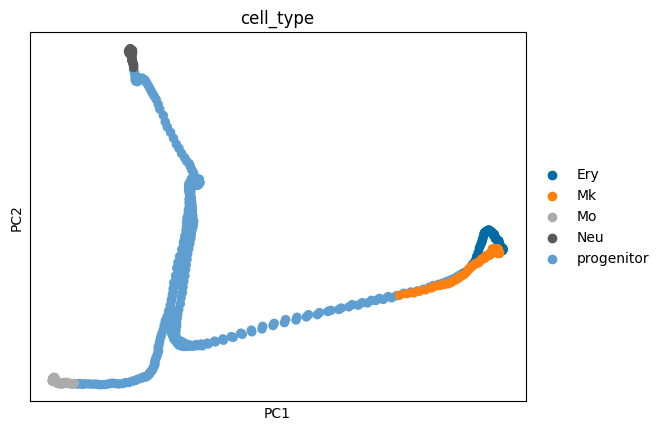

AnnData object with n_obs × n_vars = 640 × 11
    obs: 'cell_type'
    uns: 'iroot', 'highlights', 'pca', 'cell_type_colors'
    obsm: 'X_pca'
    varm: 'PCs'

In [10]:
krum_data = sc.datasets.krumsiek11()
sc.pp.pca(krum_data)
sc.pl.pca(krum_data, color='cell_type')
krum_data

In [11]:
krum_data = GmGM.GmGM(
    krum_data,
    to_keep=0.05,
    min_edges={"obs": 5, "var": 3} # to ensure the graphs have no singletons
)
print(krum_data.obsp['obs_gmgm_connectivities'])
krum_data

/usr/local/python/3.12.1/lib/python3.12/site-packages/GmGM/GmGM.py:231: UserWarning: This is outdated, will swap to using direct_left_eigenvectors in the future
  warnings.warn("This is outdated, will swap to using direct_left_eigenvectors in the future")


<Compressed Sparse Row sparse array of dtype 'float64'
	with 6898 stored elements and shape (640, 640)>
  Coords	Values
  (0, 0)	1.0003843307495117
  (0, 1)	0.002228233963251114
  (0, 2)	0.0021171681582927704
  (0, 3)	0.0020127072930336
  (0, 160)	0.004721798002719879
  (0, 161)	0.004468314349651337
  (0, 162)	0.0021242983639240265
  (0, 163)	0.0020199790596961975
  (0, 320)	0.0047209784388542175
  (0, 321)	0.004470862448215485
  (0, 322)	0.0021106377243995667
  (0, 323)	0.00201406329870224
  (0, 480)	0.004711441695690155
  (0, 481)	0.0022281035780906677
  (0, 482)	0.0021180957555770874
  (1, 0)	0.002228233963251114
  (1, 1)	1.000617504119873
  (1, 2)	0.00407940149307251
  (1, 3)	0.0039029764011502266
  (1, 4)	0.0018679331988096237
  (1, 160)	0.0022277459502220154
  (1, 161)	0.0021341387182474136
  (1, 162)	0.0020467378199100494
  (1, 163)	0.001958029344677925
  (1, 320)	0.0022268518805503845
  :	:
  (635, 635)	0.9992997646331787
  (636, 586)	0.0035009589046239853
  (636, 588)	0.003503

AnnData object with n_obs × n_vars = 640 × 11
    obs: 'cell_type'
    uns: 'iroot', 'highlights', 'pca', 'cell_type_colors', 'obs_neighbors_gmgm', 'var_neighbors_gmgm'
    obsm: 'X_pca'
    varm: 'PCs'
    obsp: 'obs_gmgm_connectivities'
    varp: 'var_gmgm_connectivities'

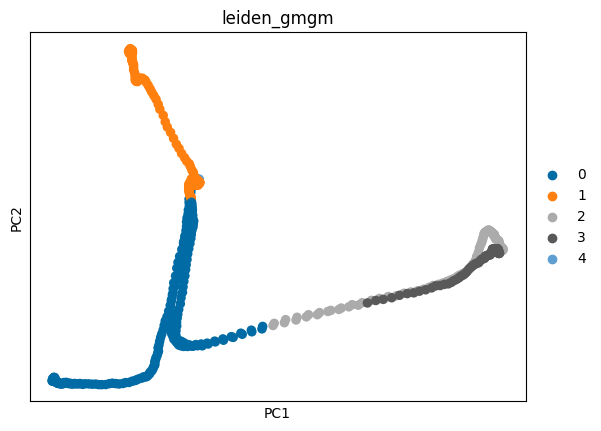

AnnData object with n_obs × n_vars = 640 × 11
    obs: 'cell_type', 'leiden_gmgm'
    uns: 'iroot', 'highlights', 'pca', 'cell_type_colors', 'obs_neighbors_gmgm', 'var_neighbors_gmgm', 'leiden_gmgm', 'leiden_gmgm_colors'
    obsm: 'X_pca'
    varm: 'PCs'
    obsp: 'obs_gmgm_connectivities'
    varp: 'var_gmgm_connectivities'

In [12]:
if 'leiden_gmgm_colors' in krum_data.uns:
    del krum_data.uns['leiden_gmgm_colors']
sc.tl.leiden(krum_data, obsp='obs_gmgm_connectivities', key_added='leiden_gmgm', resolution=0.01)
sc.pl.pca(krum_data, color='leiden_gmgm')
krum_data

In [13]:
print(
    metrics.adjusted_rand_score(krum_data.obs['cell_type'], krum_data.obs['leiden_gmgm']),
    metrics.homogeneity_score(krum_data.obs['cell_type'], krum_data.obs['leiden_gmgm']),
    metrics.completeness_score(krum_data.obs['cell_type'], krum_data.obs['leiden_gmgm']),
)



0.34398761446652665 0.5888898113179117 0.5877330222094983


In [14]:
nonzero = (krum_data.obsp['obs_gmgm_connectivities'] != 0).sum()
print(f"Nonzero elements: {nonzero}")

Nonzero elements: 6898


In [15]:
# We found this very finnicky to set up, hence our decisions in how to preprocess the data
# preprocessing we do to the data.  Without these steps, GLasso would fail to converge and/or
# throw errors.
data = krum_data.X
data = StandardScaler().fit_transform(data)
emp_cov = (data @ data.T).astype(float)

# Let's use correlation rather than covariance, for better convergence
denominator = 1 / np.sqrt(np.diag(emp_cov)).reshape(1, -1)
emp_cov = denominator.T * emp_cov * denominator

try:
    goutput = glasso(
        emp_cov,
        alpha=0.9997915933, # manually tuned to give same #nonzero as GmGM
        max_iter=1000,
    )
except FloatingPointError:
    print("System is allegedly ill-conditioned.")
    goutput = None
print(f"Nonzero elements: {(goutput[1] != 0).sum()}")

krum_data.obsp["obs_glasso_connectivities"] = np.abs(goutput[1])
krum_data

Nonzero elements: 6898


AnnData object with n_obs × n_vars = 640 × 11
    obs: 'cell_type', 'leiden_gmgm'
    uns: 'iroot', 'highlights', 'pca', 'cell_type_colors', 'obs_neighbors_gmgm', 'var_neighbors_gmgm', 'leiden_gmgm', 'leiden_gmgm_colors'
    obsm: 'X_pca'
    varm: 'PCs'
    obsp: 'obs_gmgm_connectivities', 'obs_glasso_connectivities'
    varp: 'var_gmgm_connectivities'

In [16]:
print("Number of connected components: ", csgraph.connected_components(goutput[1])[0])
sc.tl.leiden(krum_data, obsp='obs_glasso_connectivities', key_added='leiden_glasso', resolution=0.1)
print(
    metrics.adjusted_rand_score(krum_data.obs['cell_type'], krum_data.obs['leiden_glasso']),
    metrics.homogeneity_score(krum_data.obs['cell_type'], krum_data.obs['leiden_glasso']),
    metrics.completeness_score(krum_data.obs['cell_type'], krum_data.obs['leiden_glasso']),
)

Number of connected components:  266
0.009813442872662368 1.0 0.23434361478074547


In [17]:
# Iterate through every pair (i, j) such that (i < j)
good_edges = 0
total_edges = 0
for (i, j) in itertools.combinations(range(640), 2):
    edge_val = krum_data.obsp['obs_gmgm_connectivities'][i, j]
    if edge_val == 0:
        continue
    total_edges += 1
    if krum_data.obs["cell_type"].iloc[i] == krum_data.obs["cell_type"].iloc[j]:
        good_edges += 1

print(good_edges / total_edges)

good_edges = 0
total_edges = 0
for (i, j) in itertools.combinations(range(640), 2):
    edge_val = krum_data.obsp['obs_glasso_connectivities'][i, j]
    if edge_val == 0:
        continue
    total_edges += 1
    if krum_data.obs["cell_type"].iloc[i] == krum_data.obs["cell_type"].iloc[j]:
        good_edges += 1

print(good_edges / total_edges)

0.5413870246085011
0.9990412272291467


In this case, Glasso looks to be doing much better!  What's going on?

In [18]:
krum_data = GmGM.GmGM(
    krum_data,
    to_keep=0.05,
    min_edges={"obs": 5, "var": 3}, # to ensure the graphs have no singletons
    centering_method='avg-overall'
)
print(krum_data.obsp['obs_gmgm_connectivities'])
krum_data

/usr/local/python/3.12.1/lib/python3.12/site-packages/GmGM/GmGM.py:231: UserWarning: This is outdated, will swap to using direct_left_eigenvectors in the future
  warnings.warn("This is outdated, will swap to using direct_left_eigenvectors in the future")


<Compressed Sparse Row sparse array of dtype 'float64'
	with 6864 stored elements and shape (640, 640)>
  Coords	Values
  (0, 0)	1.000064730644226
  (0, 160)	0.0026100650429725647
  (0, 161)	0.0023971349000930786
  (0, 320)	0.00523202121257782
  (0, 321)	0.002405155450105667
  (0, 480)	0.0026064030826091766
  (1, 1)	1.000452995300293
  (1, 320)	0.004793666303157806
  (1, 321)	0.002234462648630142
  (1, 480)	0.002388168126344681
  (1, 481)	0.0022182539105415344
  (1, 482)	0.0020930245518684387
  (2, 2)	1.0006784200668335
  (2, 160)	0.002234560903161764
  (2, 161)	0.002102125436067581
  (2, 320)	0.004478686489164829
  (2, 321)	0.0021090349182486534
  (2, 480)	0.002231225371360779
  (3, 3)	1.0008139610290527
  (3, 160)	0.0021171122789382935
  (3, 161)	0.00200778990983963
  (3, 320)	0.004243452101945877
  (3, 321)	0.002014494501054287
  (3, 480)	0.0021141991019248962
  (4, 4)	1.0009138584136963
  :	:
  (635, 635)	0.9989783763885498
  (636, 588)	0.0037475023418664932
  (636, 597)	0.00374719

AnnData object with n_obs × n_vars = 640 × 11
    obs: 'cell_type', 'leiden_gmgm', 'leiden_glasso'
    uns: 'iroot', 'highlights', 'pca', 'cell_type_colors', 'obs_neighbors_gmgm', 'var_neighbors_gmgm', 'leiden_gmgm', 'leiden_gmgm_colors', 'leiden_glasso'
    obsm: 'X_pca'
    varm: 'PCs'
    obsp: 'obs_gmgm_connectivities', 'obs_glasso_connectivities'
    varp: 'var_gmgm_connectivities'

In [19]:
good_edges = 0
total_edges = 0
for (i, j) in itertools.combinations(range(640), 2):
    edge_val = krum_data.obsp['obs_gmgm_connectivities'][i, j]
    if edge_val == 0:
        continue
    total_edges += 1
    if krum_data.obs["cell_type"].iloc[i] == krum_data.obs["cell_type"].iloc[j]:
        good_edges += 1

print(good_edges / total_edges)

0.7284704370179949


In [20]:
dataset_gmgm_noncentral = GmGM.Dataset(
    dataset={'data': krum_data.X},
    structure={'data': (f'cell', f'gene')},
    batch_axes=None
)
def gmgm_estimator(data):
    output = GmGM.GmGM(
        data,
        to_keep=0.05,
        min_edges={"cell": 5, "gene": 3}, # to ensure the graphs have no singletons
    )
    return output.precision_matrices
NKS = NoncentralKS(
    gmgm_estimator,
    ({"gene": np.zeros(11), "cell": np.zeros(640)}, 0),
    {"gene": np.eye(11), "cell": np.eye(640)},
)
class result_container:
    # Jerry-rigged class to hold the result
    def __init__(self, precmats):
        self.precision_matrices = precmats

means_gmgm_noncentral, results_gmgm_noncentral = NKS.fit(
    dataset_gmgm_noncentral,
    verbose=True,
    tol=1e-10,
    max_iter=10
)

Iteration: 1 (Change: 30.30062461161969)
Iteration: 2 (Change: 1.6094277219893085)
Iteration: 3 (Change: 0.019367285553037034)
Iteration: 4 (Change: 0.00012063430735978675)
Iteration: 5 (Change: 2.299973981653179e-06)
Iteration: 6 (Change: 7.270134517921133e-10)
Converged in 7 iterations
Iteration: 7 (Change: 0.0)


In [21]:
krum_data.obsp['obs_nc_gmgm_connectivities'] = results_gmgm_noncentral['cell']
krum_data.varp['var_nc_gmgm_connectivities'] = results_gmgm_noncentral['gene']
results_gmgm_noncentral['cell']

<Compressed Sparse Row sparse array of dtype 'float64'
	with 6890 stored elements and shape (640, 640)>

In [22]:
good_edges = 0
total_edges = 0
for (i, j) in itertools.combinations(range(640), 2):
    edge_val = krum_data.obsp['obs_nc_gmgm_connectivities'][i, j]
    if edge_val == 0:
        continue
    total_edges += 1
    if krum_data.obs["cell_type"].iloc[i] == krum_data.obs["cell_type"].iloc[j]:
        good_edges += 1

print(good_edges / total_edges)

0.57632


In [91]:
# This cell contains the code that will plot our gene subsets

shape_palette = 100*[
   "circle",
   "rect",
   "diamond",
   "triangle",
   "rect",
   "circle",
   "triangle"
]
color_palette = 100*[
   "#FF9A96",
   "#264589",
   "#FF9A96",
   "#264589",
   "#FF9A96",
   "#264589",
   "#FF9A96"
]


def plot_info(
   name: str,
   adata: ad.AnnData,
   no_edge_weights: bool = True,
   layout: Optional[str] = None,
   graph_type = 'var_nc_gmgm_connectivities',
   color_type = None,
   fig = None,
   ax = None
) -> tuple[plt.Figure, plt.Axes]:
    random.seed(1)
    if graph_type in adata.varp:
        graph = adata.varp[graph_type]
        try:
            graph = graph.toarray()
        except:
            pass
        np.fill_diagonal(graph, 0)
    else:
        raise Exception(f"Invalid graph type: {graph_type}")
    how_many = graph.shape[0]

    try:
        # If the graph is empty, this throws an error!
        graph = ig.Graph.Weighted_Adjacency(graph, mode="undirected")
    except:
        graph = ig.Graph.Weighted_Adjacency(graph)
    graph.vs["label"] = adata.var_names
    graph.vs["label_size"] = 5

    # Get connected components of the graph
    components = graph.components()

    # Color vertex by component
    if color_type is None:
        graph.vs["color"] = [color_palette[i] for i in components.membership]
    else:
        graph.vs["color"] = [color_palette[0] if is_true else color_palette[1] for is_true in adata.var[color_type]]

    # Change  vertex shape by component as well
    graph.vs["shape"] = [shape_palette[i] for i in components.membership]

    graph.es["label"] = [f"{w:.2E}" for w in graph.es["weight"]]
    graph.es["label_size"] = 5

    if layout is None:
        layout = 'circle' if how_many > 15 else 'kk'

    if fig is None and ax is None:
        fig, ax = plt.subplots(figsize=(7, 7))
    elif fig is None or ax is None:
        raise Exception("Either both fig and ax should be specified, or neither")
    ig.plot(
        graph,
        vertex_size=40,
        target=ax,
        edge_color="black",
        layout=layout,
        **({} if no_edge_weights else {'edge_label': graph.es["label"]}),
    )
    ax.set_facecolor("white")
    ax.set_title(name)

    if color_type is None:
        ax.set_xlabel("Colored/shaped by connected components")
    else:
        ax.set_xlabel(f"Colored by {color_type}")


    fig.suptitle(f"Connections of {name}")
    return fig, ax


AnnData object with n_obs × n_vars = 640 × 11
    obs: 'cell_type', 'leiden_gmgm', 'leiden_glasso'
    uns: 'iroot', 'highlights', 'pca', 'cell_type_colors', 'obs_neighbors_gmgm', 'var_neighbors_gmgm', 'leiden_gmgm', 'leiden_gmgm_colors', 'leiden_glasso'
    obsm: 'X_pca'
    varm: 'PCs'
    obsp: 'obs_gmgm_connectivities', 'obs_glasso_connectivities', 'obs_nc_gmgm_connectivities'
    varp: 'var_gmgm_connectivities', 'var_nc_gmgm_connectivities'

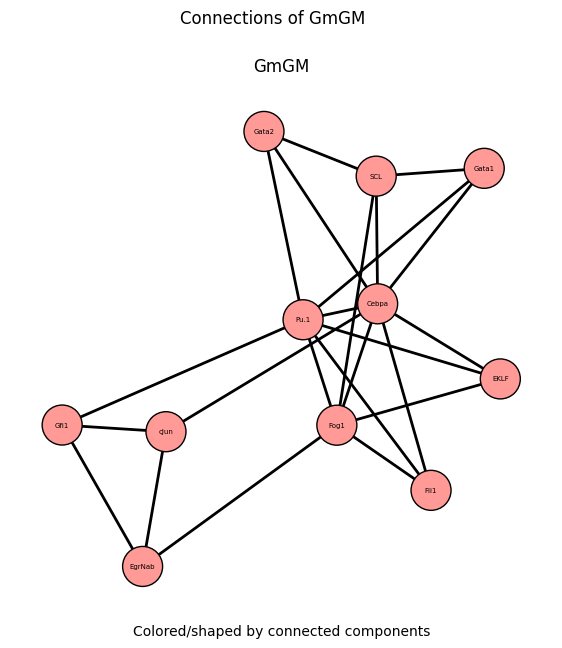

In [24]:
plot_info(
   "GmGM",
   krum_data,
   layout='fr',
   graph_type='var_gmgm_connectivities'
)
krum_data

In [25]:
def plot_cells(
   name: str,
   adata: ad.AnnData,
   no_edge_weights: bool = True,
   layout: Optional[str] = None,
   graph_type ='var_nc_gmgm_connectivities',
   fig = None,
   ax = None,
   legend_loc = 'upper right'
) -> tuple[plt.Figure, plt.Axes]:
    random.seed(1)
    if graph_type in adata.obsp:
        graph = adata.obsp[graph_type]
        try:
            graph = graph.toarray()
        except:
            pass
        np.fill_diagonal(graph, 0)
    else:
        raise Exception(f"Invalid graph type: {graph_type}")
    how_many = graph.shape[0]

    try:
        # If the graph is empty, this throws an error!
        graph = ig.Graph.Weighted_Adjacency(graph, mode="undirected")
    except:
        graph = ig.Graph.Weighted_Adjacency(graph)

    # Get connected components of the graph
    components = graph.components()

    # Map cell types to integers and use igraph’s default palette
    cell_types = adata.obs['cell_type']
    type_to_color = {ctype: adata.uns['cell_type_colors'][i % len(adata.uns['cell_type_colors'])] for i, ctype in enumerate(cell_types.unique())}
    graph.vs["color"] = cell_types.map(type_to_color).tolist()
    graph.vs["edge_color"] = graph.vs["color"]
    #graph.vs["label"] = cell_types
    #graph.vs["label_size"] = 5
    #graph.vs["label"] = cell_types.str[0]
    #graph.vs["label_size"] = 5

    # Change  vertex shape by component as well
    #graph.vs["shape"] = [shape_palette[i] for i in components.membership]
    
    type_to_shape = {ctype: shape_palette[i % len(shape_palette)] for i, ctype in enumerate(cell_types.unique())}
    graph.vs["shape"] = cell_types.map(type_to_shape).tolist()

    graph.es["label"] = [f"{w:.2E}" for w in graph.es["weight"]]
    graph.es["label_size"] = 5

    if layout is None:
        layout = 'circle' if how_many > 15 else 'kk'

    ig.plot(
        graph,
        vertex_size=10,
        target=ax,
        edge_color="black",
        layout=layout,
        **({} if no_edge_weights else {'edge_label': graph.es["label"]}),
    )
    ax.set_facecolor("white")
    ax.set_title(name)
    ax.set_xlabel("Colored/shaped by cell type")

    patches = [
        mpatches.Patch(color=color, label=label)
        for color, label
        in zip(adata.uns['cell_type_colors'], cell_types.unique())
    ]
    ax.legend(handles=patches, loc=legend_loc)
    return fig, ax

AnnData object with n_obs × n_vars = 640 × 11
    obs: 'cell_type', 'leiden_gmgm', 'leiden_glasso'
    uns: 'iroot', 'highlights', 'pca', 'cell_type_colors', 'obs_neighbors_gmgm', 'var_neighbors_gmgm', 'leiden_gmgm', 'leiden_gmgm_colors', 'leiden_glasso'
    obsm: 'X_pca'
    varm: 'PCs'
    obsp: 'obs_gmgm_connectivities', 'obs_glasso_connectivities', 'obs_nc_gmgm_connectivities'
    varp: 'var_gmgm_connectivities', 'var_nc_gmgm_connectivities'

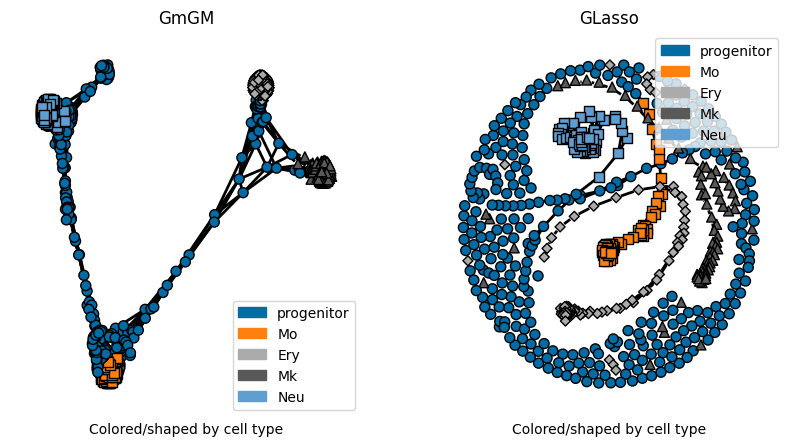

In [26]:
fig, (ax1, ax2) = plt.subplots(figsize=(10, 5), ncols=2)
plot_cells(
   "GmGM",
   krum_data,
   layout='fr',
   graph_type='obs_gmgm_connectivities',
   fig=fig,
   ax=ax1,
   legend_loc='lower right'
)
plot_cells(
   "GLasso",
   krum_data,
   layout='fr',
   graph_type='obs_glasso_connectivities',
   fig=fig,
   ax=ax2
)
krum_data

In [27]:
# Iterate through every pair (i, j) such that (i < j)
good_edges = 0
total_edges = 0
good_nonedges = 0
total_nonedges = 0
for (i, j) in itertools.combinations(range(640), 2):
    edge_val = krum_data.obsp['obs_gmgm_connectivities'][i, j]
    if edge_val == 0:
        total_nonedges += 1
        if krum_data.obs["cell_type"].iloc[i] != krum_data.obs["cell_type"].iloc[j]:
            good_nonedges += 1
        continue
    total_edges += 1
    if krum_data.obs["cell_type"].iloc[i] == krum_data.obs["cell_type"].iloc[j]:
        good_edges += 1

print(good_edges / total_edges)
print(good_nonedges / total_nonedges)

good_edges = 0
total_edges = 0
good_nonedges = 0
total_nonedges = 0
for (i, j) in itertools.combinations(range(640), 2):
    edge_val = krum_data.obsp['obs_glasso_connectivities'][i, j]
    if edge_val == 0:
        total_nonedges += 1
        if krum_data.obs["cell_type"].iloc[i] != krum_data.obs["cell_type"].iloc[j]:
            good_nonedges += 1
        continue
    total_edges += 1
    if krum_data.obs["cell_type"].iloc[i] == krum_data.obs["cell_type"].iloc[j]:
        good_edges += 1

print(good_edges / total_edges)
print(good_nonedges / total_nonedges)




0.7284704370179949
0.6950210559771165
0.9990412272291467
0.6992614886442083


In [28]:
krum_data = GmGM.GmGM(
    krum_data,
    to_keep={"obs": 5, "var": 3},
    min_edges={"obs": 0, "var": 0},
    threshold_method="rowwise-col-weighted"
)
print(krum_data.obsp['obs_gmgm_connectivities'])
krum_data

<Compressed Sparse Row sparse array of dtype 'float32'
	with 6836 stored elements and shape (640, 640)>
  Coords	Values
  (0, 0)	0.0
  (0, 160)	0.0023608990013599396
  (0, 161)	0.0022341571748256683
  (0, 320)	0.0047209784388542175
  (0, 321)	0.0022354312241077423
  (0, 480)	0.0023557208478450775
  (1, 1)	0.0
  (1, 320)	0.004453703761100769
  (1, 321)	0.002134818583726883
  (1, 322)	0.0020344555377960205
  (1, 480)	0.0022227573208510876
  (1, 481)	0.0021289922297000885
  (2, 2)	0.0
  (2, 320)	0.004231221973896027
  (2, 321)	0.0020453855395317078
  (2, 322)	0.0019624680280685425
  (2, 480)	0.0021118922159075737
  (2, 481)	0.002040684223175049
  (3, 3)	0.0
  (3, 160)	0.002012487966567278
  (3, 161)	0.0019562896341085434
  (3, 320)	0.004022367298603058
  (3, 321)	0.0019566603004932404
  (3, 480)	0.0020078662782907486
  (4, 4)	0.0
  :	:
  (635, 635)	0.0
  (636, 623)	0.003477238118648529
  (636, 624)	0.00348627008497715
  (636, 625)	0.0034877918660640717
  (636, 626)	0.0034832004457712173
 

/usr/local/python/3.12.1/lib/python3.12/site-packages/GmGM/GmGM.py:231: UserWarning: This is outdated, will swap to using direct_left_eigenvectors in the future
  warnings.warn("This is outdated, will swap to using direct_left_eigenvectors in the future")


AnnData object with n_obs × n_vars = 640 × 11
    obs: 'cell_type', 'leiden_gmgm', 'leiden_glasso'
    uns: 'iroot', 'highlights', 'pca', 'cell_type_colors', 'obs_neighbors_gmgm', 'var_neighbors_gmgm', 'leiden_gmgm', 'leiden_gmgm_colors', 'leiden_glasso'
    obsm: 'X_pca'
    varm: 'PCs'
    obsp: 'obs_gmgm_connectivities', 'obs_glasso_connectivities', 'obs_nc_gmgm_connectivities'
    varp: 'var_gmgm_connectivities', 'var_nc_gmgm_connectivities'

AnnData object with n_obs × n_vars = 640 × 11
    obs: 'cell_type', 'leiden_gmgm', 'leiden_glasso'
    uns: 'iroot', 'highlights', 'pca', 'cell_type_colors', 'obs_neighbors_gmgm', 'var_neighbors_gmgm', 'leiden_gmgm', 'leiden_gmgm_colors', 'leiden_glasso'
    obsm: 'X_pca'
    varm: 'PCs'
    obsp: 'obs_gmgm_connectivities', 'obs_glasso_connectivities', 'obs_nc_gmgm_connectivities'
    varp: 'var_gmgm_connectivities', 'var_nc_gmgm_connectivities'

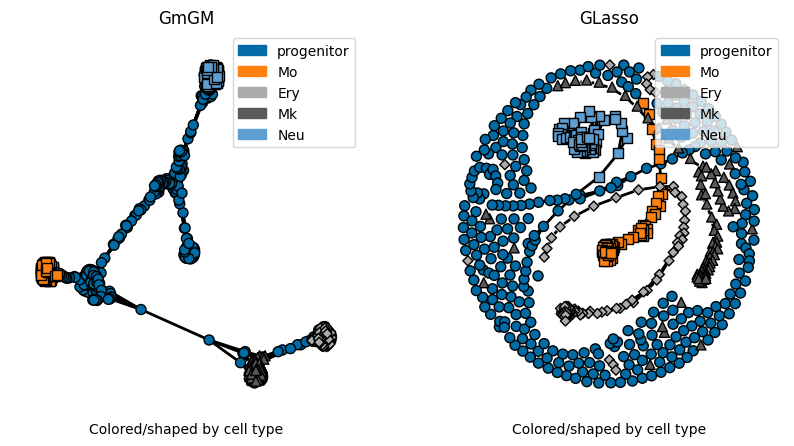

In [29]:
fig, (ax1, ax2) = plt.subplots(figsize=(10, 5), ncols=2)
plot_cells(
   "GmGM",
   krum_data,
   layout='fr',
   graph_type='obs_gmgm_connectivities',
   fig=fig,
   ax=ax1
)
plot_cells(
   "GLasso",
   krum_data,
   layout='fr',
   graph_type='obs_glasso_connectivities',
   fig=fig,
   ax=ax2
)
krum_data

In [30]:
# This may take ~30 seconds
sp_results = strong_product_model(
    krum_data.X,
    rho_rows=1e-3,
    rho_cols_within_rows=1e-3,
    rho_cols_between_rows=1e-3,
    verbose=True,
    tol=1e-8
)

# We have to do the thresholding ourselves for this algorithm
sp_cells = np.abs(sp_results['rows'])
np.fill_diagonal(sp_cells, 0)

# Keep the same amount of edges as from GmGM
to_keep = krum_data.obsp['obs_gmgm_connectivities'].nnz - 640
percentile = 100 - to_keep / 640**2 * 100
threshold = np.percentile(sp_cells, percentile)
sp_cells[sp_cells < threshold] = 0
sp_cells = sparse.csr_array(sp_cells)
krum_data.obsp['obs_sp_connectivities'] = sp_cells

sp_cells

Iteration 0: -3159.514256669987
Iteration 1: -13372.69521627399
Iteration 2: -17133.421266839432


/home/codespace/.local/lib/python3.12/site-packages/scipy/linalg/_matfuncs.py:373: RuntimeWarning: overflow encountered in matmul
  eAw = eAw @ eAw
/home/codespace/.local/lib/python3.12/site-packages/scipy/linalg/_matfuncs.py:373: RuntimeWarning: invalid value encountered in matmul
  eAw = eAw @ eAw
/workspaces/ellis-summerschool/notebooks/strong_product_model.py:287: RuntimeWarning: invalid value encountered in matmul
  Theta = old_Theta @ linalg.expm(-lr * C)
/workspaces/ellis-summerschool/notebooks/strong_product_model.py:317: RuntimeWarning: invalid value encountered in matmul
  Theta = old_Theta @ linalg.expm(-lr * C)


Iteration 3: -17726.80437820772
Iteration 4: -17726.804378207795 (converged)


<Compressed Sparse Row sparse array of dtype 'float64'
	with 6196 stored elements and shape (640, 640)>

AnnData object with n_obs × n_vars = 640 × 11
    obs: 'cell_type', 'leiden_gmgm', 'leiden_glasso'
    uns: 'iroot', 'highlights', 'pca', 'cell_type_colors', 'obs_neighbors_gmgm', 'var_neighbors_gmgm', 'leiden_gmgm', 'leiden_gmgm_colors', 'leiden_glasso'
    obsm: 'X_pca'
    varm: 'PCs'
    obsp: 'obs_gmgm_connectivities', 'obs_glasso_connectivities', 'obs_nc_gmgm_connectivities', 'obs_sp_connectivities'
    varp: 'var_gmgm_connectivities', 'var_nc_gmgm_connectivities'

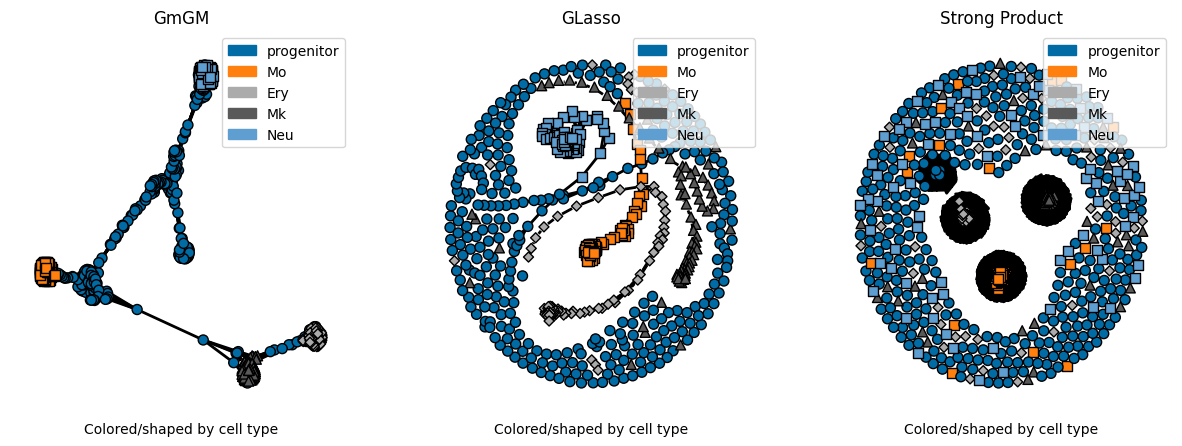

In [31]:
fig, (ax1, ax2, ax3) = plt.subplots(figsize=(15, 5), ncols=3)
plot_cells(
   "GmGM",
   krum_data,
   layout='fr',
   graph_type='obs_gmgm_connectivities',
   fig=fig,
   ax=ax1
)
plot_cells(
   "GLasso",
   krum_data,
   layout='fr',
   graph_type='obs_glasso_connectivities',
   fig=fig,
   ax=ax2
)
plot_cells(
   "Strong Product",
   krum_data,
   layout='fr',
   graph_type='obs_sp_connectivities',
   fig=fig,
   ax=ax3
)
krum_data

Interestingly, all methods have their own pros and cons.

1) GmGM does the best at capturing the global structure.
2) GLasso's "linearity" in the graph implies it's doing a good job capturing the local structure, but it systemically fails to connect progenitors (blue circles), leading to lots of singletons.
3) The Strong Product does a great job tightly clustering the cells, but does not capture any temporal information.

In [32]:
# Iterate through every pair (i, j) such that (i < j)
good_edges = 0
total_edges = 0
good_nonedges = 0
total_nonedges = 0
for (i, j) in itertools.combinations(range(640), 2):
    edge_val = krum_data.obsp['obs_gmgm_connectivities'][i, j]
    if edge_val == 0:
        total_nonedges += 1
        if krum_data.obs["cell_type"].iloc[i] != krum_data.obs["cell_type"].iloc[j]:
            good_nonedges += 1
        continue
    total_edges += 1
    if krum_data.obs["cell_type"].iloc[i] == krum_data.obs["cell_type"].iloc[j]:
        good_edges += 1

print("GmGM")
print(good_edges / total_edges)
print(good_nonedges / total_nonedges)

good_edges = 0
total_edges = 0
good_nonedges = 0
total_nonedges = 0
for (i, j) in itertools.combinations(range(640), 2):
    edge_val = krum_data.obsp['obs_glasso_connectivities'][i, j]
    if edge_val == 0:
        total_nonedges += 1
        if krum_data.obs["cell_type"].iloc[i] != krum_data.obs["cell_type"].iloc[j]:
            good_nonedges += 1
        continue
    total_edges += 1
    if krum_data.obs["cell_type"].iloc[i] == krum_data.obs["cell_type"].iloc[j]:
        good_edges += 1

print("GLasso")
print(good_edges / total_edges)
print(good_nonedges / total_nonedges)

good_edges = 0
total_edges = 0
good_nonedges = 0
total_nonedges = 0
for (i, j) in itertools.combinations(range(640), 2):
    edge_val = krum_data.obsp['obs_sp_connectivities'][i, j]
    if edge_val == 0:
        total_nonedges += 1
        if krum_data.obs["cell_type"].iloc[i] != krum_data.obs["cell_type"].iloc[j]:
            good_nonedges += 1
        continue
    total_edges += 1
    if krum_data.obs["cell_type"].iloc[i] == krum_data.obs["cell_type"].iloc[j]:
        good_edges += 1

print("Strong Product")
print(good_edges / total_edges)
print(good_nonedges / total_nonedges)


GmGM
0.8637830858618464
0.6970732240220079
GLasso
0.9990412272291467
0.6992614886442083
Strong Product
1.0
0.6991687439791043


In [33]:
gmgm_graph = ig.Graph.Weighted_Adjacency(
    krum_data.obsp['obs_gmgm_connectivities'].toarray(),
    mode="undirected"
)
gmgm_graph.vs['cell_type'] = krum_data.obs['cell_type'].astype("category").cat.codes.tolist()
print(
    "GmGM Assortativity: ",
    gmgm_graph.assortativity_nominal('cell_type')
)

glasso_graph = ig.Graph.Weighted_Adjacency(
    krum_data.obsp['obs_glasso_connectivities'],
    mode="undirected"
)
glasso_graph.vs['cell_type'] = krum_data.obs['cell_type'].astype("category").cat.codes.tolist()
print(
    "GLasso Assortativity: ",
    glasso_graph.assortativity_nominal('cell_type')
)

sp_graph = ig.Graph.Weighted_Adjacency(
    krum_data.obsp['obs_sp_connectivities'].toarray() + krum_data.obsp['obs_sp_connectivities'].toarray().T,
    mode="undirected"
)
sp_graph.vs['cell_type'] = krum_data.obs['cell_type'].astype("category").cat.codes.tolist()
print(
    "Strong Product Assortativity: ",
    sp_graph.assortativity_nominal('cell_type')
)

GmGM Assortativity:  0.8136210343596638
GLasso Assortativity:  0.9986310804955877
Strong Product Assortativity:  1.0


In [34]:
krum_data.obs['cell_type']

0      progenitor
1      progenitor
2      progenitor
3      progenitor
4      progenitor
          ...    
155           Neu
156           Neu
157           Neu
158           Neu
159           Neu
Name: cell_type, Length: 640, dtype: category
Categories (5, object): ['Ery', 'Mk', 'Mo', 'Neu', 'progenitor']

Text(0.5, 0.98, 'Without Progenitor Cells')

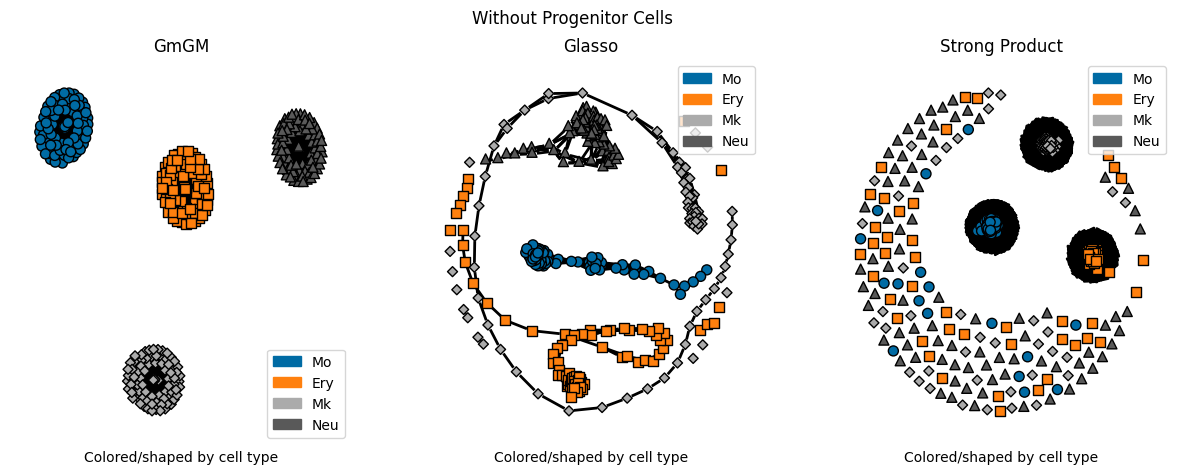

In [35]:
fig, (ax1, ax2, ax3) = plt.subplots(figsize=(15, 5), ncols=3)
plot_cells(
   "GmGM",
   krum_data[krum_data.obs['cell_type'] != 'progenitor'],
   layout='fr',
   graph_type='obs_gmgm_connectivities',
   fig=fig,
   ax=ax1,
   legend_loc='lower right'
)
plot_cells(
   "Glasso",
   krum_data[krum_data.obs['cell_type'] != 'progenitor'],
   layout='fr',
   graph_type='obs_glasso_connectivities',
   fig=fig,
   ax=ax2
)
plot_cells(
   "Strong Product",
   krum_data[krum_data.obs['cell_type'] != 'progenitor'],
   layout='fr',
   graph_type='obs_sp_connectivities',
   fig=fig,
   ax=ax3
)
fig.suptitle("Without Progenitor Cells")

Text(0.5, 0.98, 'Just Progenitor Cells')

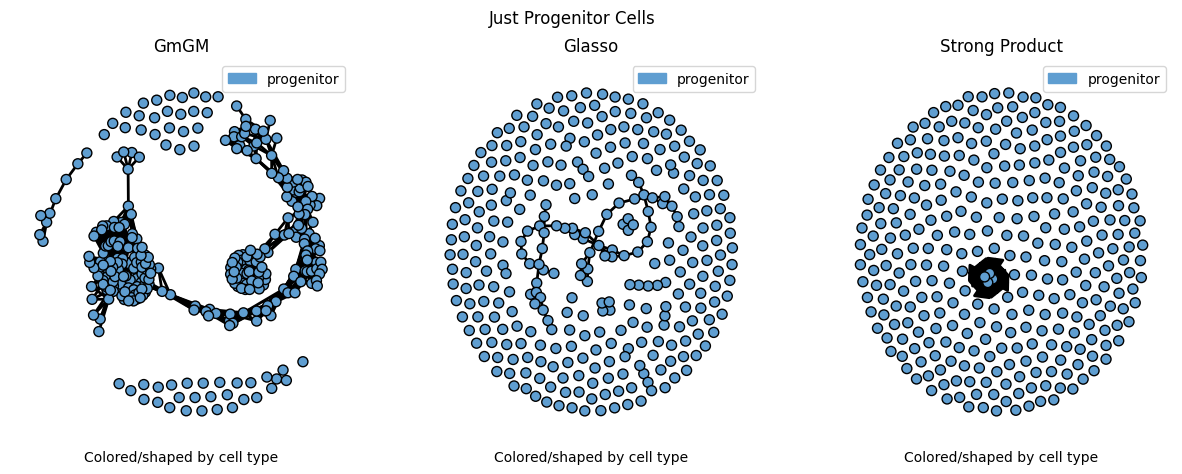

In [36]:
fig, (ax1, ax2, ax3) = plt.subplots(figsize=(15, 5), ncols=3)
plot_cells(
   "GmGM",
   krum_data[krum_data.obs['cell_type'] == 'progenitor'],
   layout='fr',
   graph_type='obs_gmgm_connectivities',
   fig=fig,
   ax=ax1
)
plot_cells(
   "Glasso",
   krum_data[krum_data.obs['cell_type'] == 'progenitor'],
   layout='fr',
   graph_type='obs_glasso_connectivities',
   fig=fig,
   ax=ax2
)
plot_cells(
   "Strong Product",
   krum_data[krum_data.obs['cell_type'] == 'progenitor'],
   layout='fr',
   graph_type='obs_sp_connectivities',
   fig=fig,
   ax=ax3
)
fig.suptitle("Just Progenitor Cells")

AnnData object with n_obs × n_vars = 640 × 11
    obs: 'cell_type', 'leiden_gmgm', 'leiden_glasso'
    uns: 'iroot', 'highlights', 'pca', 'cell_type_colors', 'obs_neighbors_gmgm', 'var_neighbors_gmgm', 'leiden_gmgm', 'leiden_gmgm_colors', 'leiden_glasso'
    obsm: 'X_pca'
    varm: 'PCs'
    obsp: 'obs_gmgm_connectivities', 'obs_glasso_connectivities', 'obs_nc_gmgm_connectivities', 'obs_sp_connectivities'
    varp: 'var_gmgm_connectivities', 'var_nc_gmgm_connectivities'

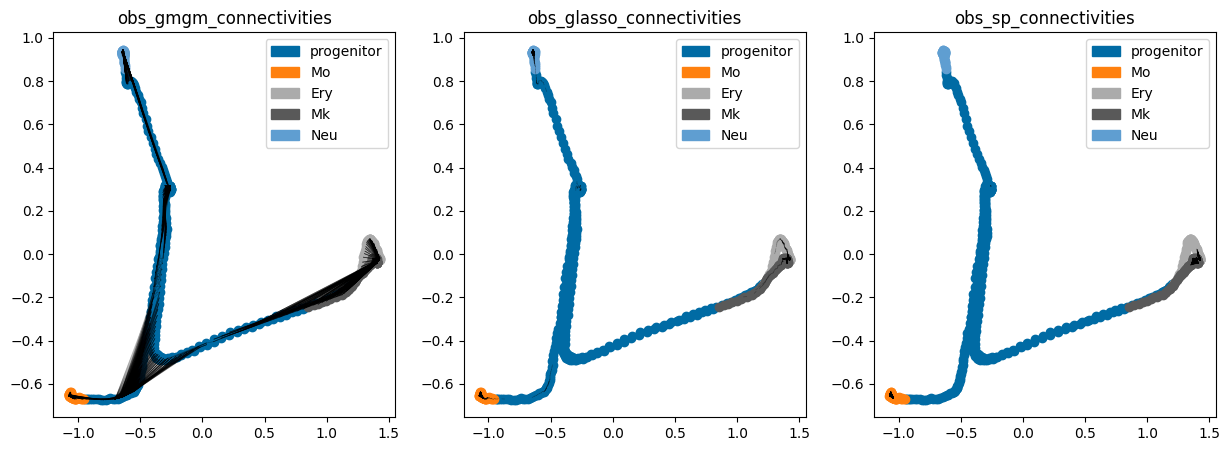

In [37]:
fig, axs = plt.subplots(figsize=(15, 5), ncols=3)

type_to_color = {ctype: krum_data.uns['cell_type_colors'][i % len(krum_data.uns['cell_type_colors'])] for i, ctype in enumerate(krum_data.obs['cell_type'].unique())}
colors = krum_data.obs['cell_type'].map(type_to_color).tolist()
graphs = ["obs_gmgm_connectivities", "obs_glasso_connectivities", "obs_sp_connectivities"]

for ax, graph in zip(axs, graphs):
    for i in range(640):
        x = [krum_data.obsm['X_pca'][i, 0]]
        y = [krum_data.obsm['X_pca'][i, 1]]
        ax.scatter(x, y, color=colors[i])
    for (i, j) in itertools.combinations(range(640), 2):
        if krum_data.obsp[graph][i, j] == 0:
            continue
        xs = krum_data.obsm['X_pca'][[i, j], 0]
        ys = krum_data.obsm['X_pca'][[i, j], 1]
        ax.plot(xs, ys, color='#00000044', linewidth=0.5)

    patches = [
        mpatches.Patch(color=color, label=label)
        for color, label
        in zip(krum_data.uns['cell_type_colors'], krum_data.obs['cell_type'].unique())
    ]
    ax.legend(handles=patches, loc='upper right')
    ax.set_title(graph)

krum_data

If we want to look at genes, need to run GLasso on that axis.

Strong Product is like GmGM, both axes are learned jointly, so just need to threshold its graphs

In [ ]:
# We have to do the thresholding ourselves for this algorithm
sp_genes1 = np.abs(sp_results['cols_within_rows'])
np.fill_diagonal(sp_genes1, 0)

# Keep the same amount of edges as from GmGM
to_keep = krum_data.varp['var_gmgm_connectivities'].nnz - 11
percentile = 100 - to_keep / 11**2 * 100
threshold = np.percentile(sp_genes1, percentile)
sp_genes1[sp_genes1 < threshold] = 0
sp_genes1 = sparse.csr_array(sp_genes1)
krum_data.varp['var_sp_within_connectivities'] = sp_genes1 + sp_genes1.T

# We have to do the thresholding ourselves for this algorithm
sp_genes2 = np.abs(sp_results['cols_between_rows'])
np.fill_diagonal(sp_genes2, 0)

# Keep the same amount of edges as from GmGM
to_keep = krum_data.varp['var_gmgm_connectivities'].nnz - 11
percentile = 100 - to_keep / 11**2 * 100
threshold = np.percentile(sp_genes2, percentile)
sp_genes2[sp_genes2 < threshold] = 0
sp_genes2 = sparse.csr_array(sp_genes2)
krum_data.varp['var_sp_between_connectivities'] = sp_genes2 + sp_genes2.T

In [39]:
krum_data.varp['var_gmgm_connectivities'].nnz

53

In [40]:
# We found this very finnicky to set up, hence our decisions in how to preprocess the data
# preprocessing we do to the data.  Without these steps, GLasso would fail to converge and/or
# throw errors.
data = krum_data.X.T
data = StandardScaler().fit_transform(data)
emp_cov = (data @ data.T).astype(float)

# Let's use correlation rather than covariance, for better convergence
denominator = 1 / np.sqrt(np.diag(emp_cov)).reshape(1, -1)
emp_cov = denominator.T * emp_cov * denominator

try:
    goutput = glasso(
        emp_cov,
        alpha=0.505, # manually tuned to give same #nonzero as GmGM
        max_iter=1000,
    )
except FloatingPointError:
    print("System is allegedly ill-conditioned.")
    goutput = None
print(f"Nonzero elements: {(goutput[1] != 0).sum()}")

krum_data.varp["var_glasso_connectivities"] = np.abs(goutput[1])
krum_data

Nonzero elements: 53


AnnData object with n_obs × n_vars = 640 × 11
    obs: 'cell_type', 'leiden_gmgm', 'leiden_glasso'
    uns: 'iroot', 'highlights', 'pca', 'cell_type_colors', 'obs_neighbors_gmgm', 'var_neighbors_gmgm', 'leiden_gmgm', 'leiden_gmgm_colors', 'leiden_glasso'
    obsm: 'X_pca'
    varm: 'PCs'
    obsp: 'obs_gmgm_connectivities', 'obs_glasso_connectivities', 'obs_nc_gmgm_connectivities', 'obs_sp_connectivities'
    varp: 'var_gmgm_connectivities', 'var_nc_gmgm_connectivities', 'var_sp_within_connectivities', 'var_sp_between_connectivities', 'var_glasso_connectivities'

AnnData object with n_obs × n_vars = 640 × 11
    obs: 'cell_type', 'leiden_gmgm', 'leiden_glasso'
    uns: 'iroot', 'highlights', 'pca', 'cell_type_colors', 'obs_neighbors_gmgm', 'var_neighbors_gmgm', 'leiden_gmgm', 'leiden_gmgm_colors', 'leiden_glasso'
    obsm: 'X_pca'
    varm: 'PCs'
    obsp: 'obs_gmgm_connectivities', 'obs_glasso_connectivities', 'obs_nc_gmgm_connectivities', 'obs_sp_connectivities'
    varp: 'var_gmgm_connectivities', 'var_nc_gmgm_connectivities', 'var_sp_within_connectivities', 'var_sp_between_connectivities', 'var_glasso_connectivities'

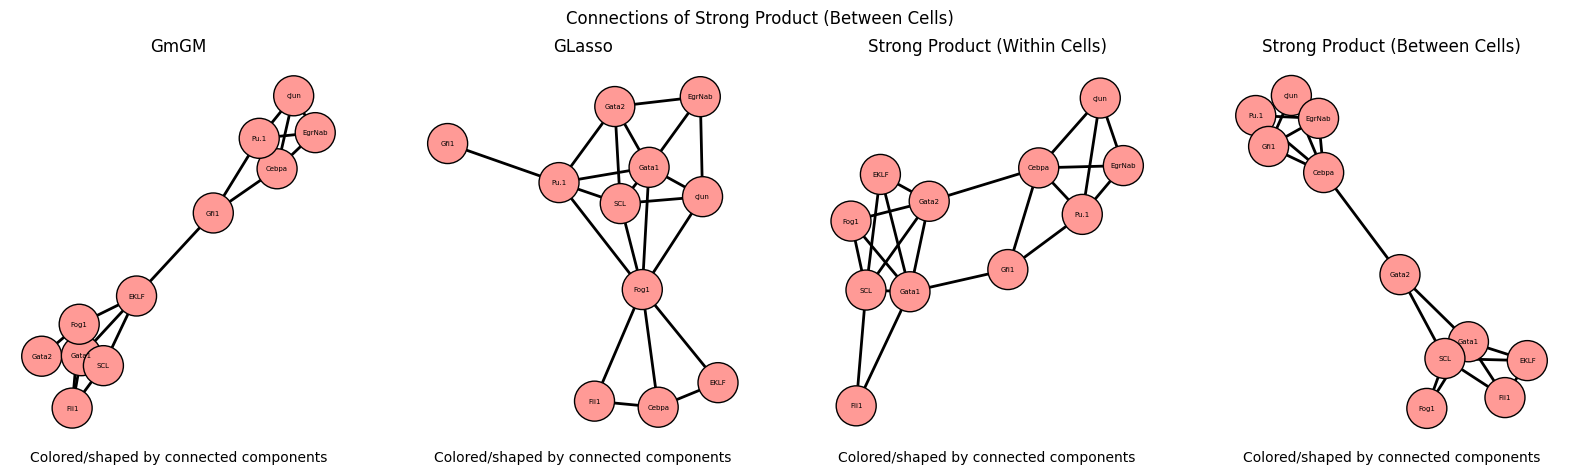

In [41]:
fig, axs = plt.subplots(figsize=(20, 5), ncols=4)
plot_info(
   "GmGM",
   krum_data,
   layout='fr',
   graph_type='var_gmgm_connectivities',
   ax=axs[0],
   fig=fig
)
plot_info(
   "GLasso",
   krum_data,
   layout='fr',
   graph_type='var_glasso_connectivities',
   ax=axs[1],
   fig=fig
)
plot_info(
   "Strong Product (Within Cells)",
   krum_data,
   layout='fr',
   graph_type='var_sp_within_connectivities',
   ax=axs[2],
   fig=fig
)
plot_info(
   "Strong Product (Between Cells)",
   krum_data,
   layout='fr',
   graph_type='var_sp_between_connectivities',
   ax=axs[3],
   fig=fig
)
krum_data

/tmp/ipykernel_3820/1438929130.py:20: UserWarning: set_ticklabels() should only be used with a fixed number of ticks, i.e. after set_ticks() or using a FixedLocator.
  ax.set_xticklabels([""] + list(allgraphs.keys()), rotation=90)
/tmp/ipykernel_3820/1438929130.py:21: UserWarning: set_ticklabels() should only be used with a fixed number of ticks, i.e. after set_ticks() or using a FixedLocator.
  ax.set_yticklabels([""] + list(allgraphs.keys()))


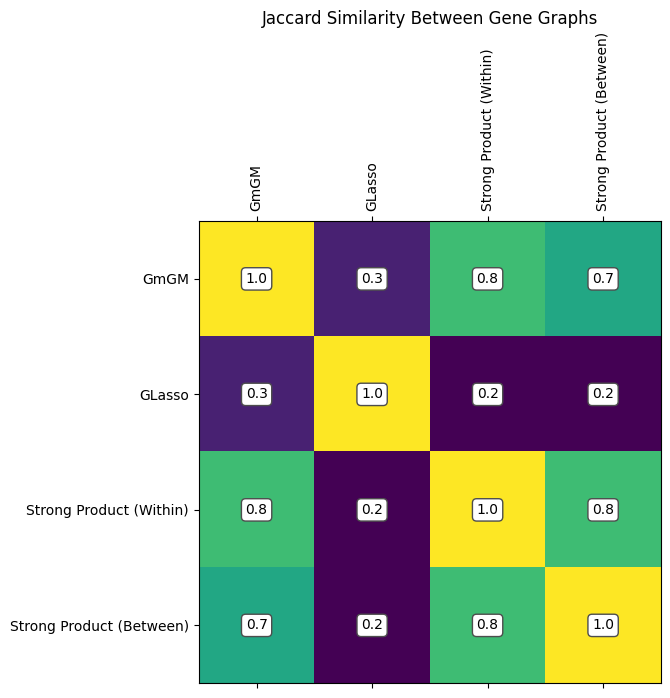

In [42]:
genes_gmgm = ig.Graph.Weighted_Adjacency(krum_data.varp["var_gmgm_connectivities"].toarray())
genes_glasso = ig.Graph.Weighted_Adjacency(krum_data.varp["var_glasso_connectivities"])
genes_sp_within = ig.Graph.Weighted_Adjacency(krum_data.varp["var_sp_within_connectivities"].toarray())
genes_sp_between = ig.Graph.Weighted_Adjacency(krum_data.varp["var_sp_between_connectivities"].toarray())

allgraphs = {
    "GmGM": genes_gmgm,
    "GLasso": genes_glasso,
    "Strong Product (Within)": genes_sp_within,
    "Strong Product (Between)": genes_sp_between
}
similarities = np.zeros((4, 4))
for (i1, (t1, g1)), (i2, (t2, g2)) in itertools.product(enumerate(allgraphs.items()), enumerate(allgraphs.items())):
    e1 = set(g1.get_edgelist())
    e2 = set(g2.get_edgelist())
    similarities[i1, i2] = len(e1 & e2) / len(e1 | e2)

fig, ax = plt.subplots(figsize=(6, 6))
ax.matshow(similarities)
ax.set_xticklabels([""] + list(allgraphs.keys()), rotation=90)
ax.set_yticklabels([""] + list(allgraphs.keys()))

for (i, j), z in np.ndenumerate(similarities):
    ax.text(j, i, '{:0.1f}'.format(z), ha='center', va='center',
            bbox=dict(boxstyle='round', facecolor='white', edgecolor='0.3'))
    
ax.set_title("Jaccard Similarity Between Gene Graphs")

pass

/tmp/ipykernel_3820/1525757462.py:20: UserWarning: set_ticklabels() should only be used with a fixed number of ticks, i.e. after set_ticks() or using a FixedLocator.
  ax.set_xticklabels([""] + list(allgraphs.keys()), rotation=90)
/tmp/ipykernel_3820/1525757462.py:21: UserWarning: set_ticklabels() should only be used with a fixed number of ticks, i.e. after set_ticks() or using a FixedLocator.
  ax.set_yticklabels([""] + list(allgraphs.keys()))


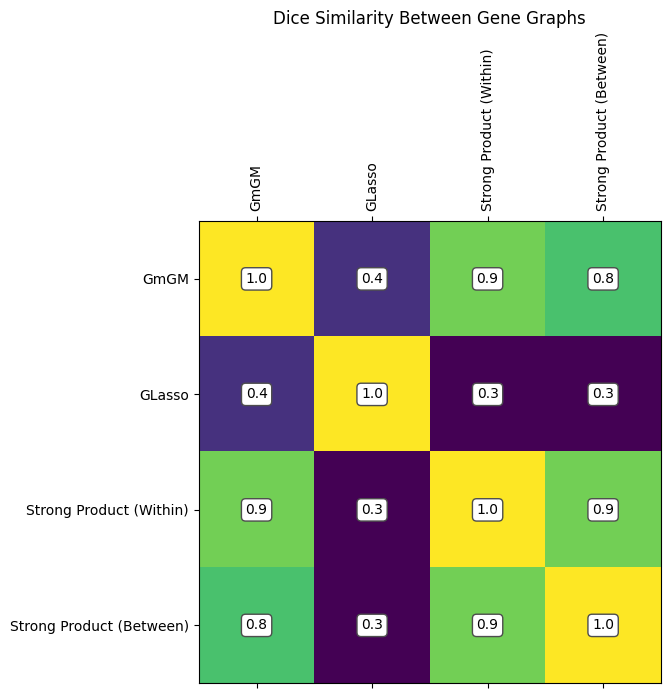

In [45]:
genes_gmgm = ig.Graph.Weighted_Adjacency(krum_data.varp["var_gmgm_connectivities"].toarray())
genes_glasso = ig.Graph.Weighted_Adjacency(krum_data.varp["var_glasso_connectivities"])
genes_sp_within = ig.Graph.Weighted_Adjacency(krum_data.varp["var_sp_within_connectivities"].toarray())
genes_sp_between = ig.Graph.Weighted_Adjacency(krum_data.varp["var_sp_between_connectivities"].toarray())

allgraphs = {
    "GmGM": genes_gmgm,
    "GLasso": genes_glasso,
    "Strong Product (Within)": genes_sp_within,
    "Strong Product (Between)": genes_sp_between
}
similarities = np.zeros((4, 4))
for (i1, (t1, g1)), (i2, (t2, g2)) in itertools.product(enumerate(allgraphs.items()), enumerate(allgraphs.items())):
    e1 = set(g1.get_edgelist())
    e2 = set(g2.get_edgelist())
    similarities[i1, i2] = 2 * len(e1 & e2) / (len(e1) + len(e2))

fig, ax = plt.subplots(figsize=(6, 6))
ax.matshow(similarities)
ax.set_xticklabels([""] + list(allgraphs.keys()), rotation=90)
ax.set_yticklabels([""] + list(allgraphs.keys()))

for (i, j), z in np.ndenumerate(similarities):
    ax.text(j, i, '{:0.1f}'.format(z), ha='center', va='center',
            bbox=dict(boxstyle='round', facecolor='white', edgecolor='0.3'))
    
ax.set_title("Dice Similarity Between Gene Graphs")

pass

In [71]:
# For K Nearest Neighbors
sc.pp.neighbors(krum_data, n_neighbors=int(krum_data.obsp['obs_gmgm_connectivities'].nnz / 640))
krum_data.obsp['connectivities']

<Compressed Sparse Row sparse matrix of dtype 'float32'
	with 6642 stored elements and shape (640, 640)>

/tmp/ipykernel_3820/2724152353.py:20: UserWarning: set_ticklabels() should only be used with a fixed number of ticks, i.e. after set_ticks() or using a FixedLocator.
  ax.set_xticklabels([""] + list(allgraphs.keys()), rotation=90)
/tmp/ipykernel_3820/2724152353.py:21: UserWarning: set_ticklabels() should only be used with a fixed number of ticks, i.e. after set_ticks() or using a FixedLocator.
  ax.set_yticklabels([""] + list(allgraphs.keys()))


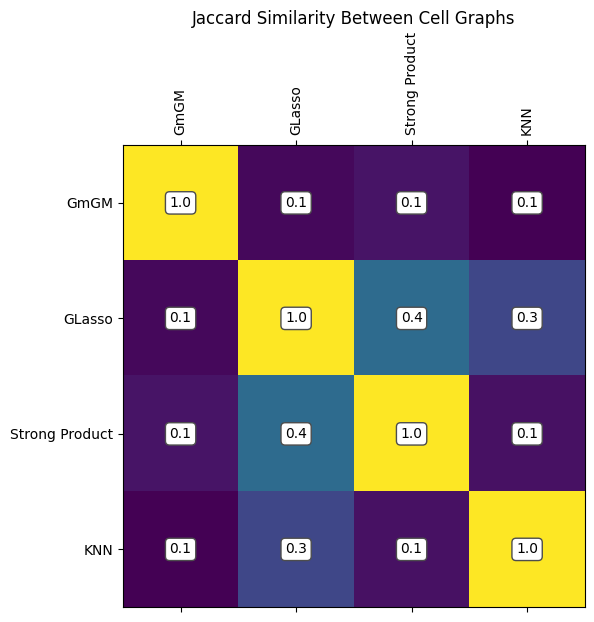

In [73]:
cells_gmgm = ig.Graph.Weighted_Adjacency(krum_data.obsp["obs_gmgm_connectivities"].toarray())
cells_glasso = ig.Graph.Weighted_Adjacency(krum_data.obsp["obs_glasso_connectivities"])
cells_sp = ig.Graph.Weighted_Adjacency(krum_data.obsp["obs_sp_connectivities"].toarray())
cells_knn = ig.Graph.Weighted_Adjacency(krum_data.obsp["connectivities"].toarray())

allgraphs = {
    "GmGM": cells_gmgm,
    "GLasso": cells_glasso,
    "Strong Product": cells_sp,
    "KNN": cells_knn
}
similarities = np.zeros((4, 4))
for (i1, (t1, g1)), (i2, (t2, g2)) in itertools.product(enumerate(allgraphs.items()), enumerate(allgraphs.items())):
    e1 = set(g1.get_edgelist())
    e2 = set(g2.get_edgelist())
    similarities[i1, i2] = len(e1 & e2) / len(e1 | e2)

fig, ax = plt.subplots(figsize=(6, 6))
ax.matshow(similarities)
ax.set_xticklabels([""] + list(allgraphs.keys()), rotation=90)
ax.set_yticklabels([""] + list(allgraphs.keys()))

for (i, j), z in np.ndenumerate(similarities):
    ax.text(j, i, '{:0.1f}'.format(z), ha='center', va='center',
            bbox=dict(boxstyle='round', facecolor='white', edgecolor='0.3'))
    
ax.set_title("Jaccard Similarity Between Cell Graphs")

pass

/tmp/ipykernel_3820/1242315348.py:15: UserWarning: set_ticklabels() should only be used with a fixed number of ticks, i.e. after set_ticks() or using a FixedLocator.
  ax.set_xticklabels([""] + list(allgraphs.keys()), rotation=90)
/tmp/ipykernel_3820/1242315348.py:16: UserWarning: set_ticklabels() should only be used with a fixed number of ticks, i.e. after set_ticks() or using a FixedLocator.
  ax.set_yticklabels([""] + list(allgraphs.keys()))


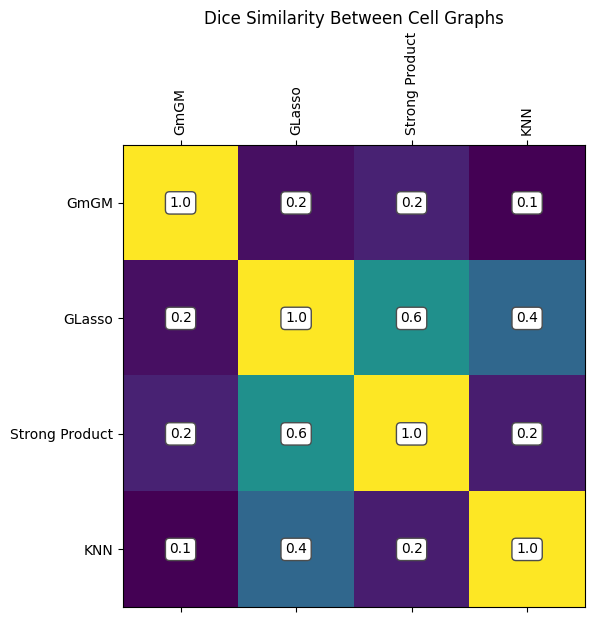

In [74]:
allgraphs = {
    "GmGM": cells_gmgm,
    "GLasso": cells_glasso,
    "Strong Product": cells_sp,
    "KNN": cells_knn
}
similarities = np.zeros((4, 4))
for (i1, (t1, g1)), (i2, (t2, g2)) in itertools.product(enumerate(allgraphs.items()), enumerate(allgraphs.items())):
    e1 = set(g1.get_edgelist())
    e2 = set(g2.get_edgelist())
    similarities[i1, i2] = 2 * len(e1 & e2) / (len(e1) + len(e2))

fig, ax = plt.subplots(figsize=(6, 6))
ax.matshow(similarities)
ax.set_xticklabels([""] + list(allgraphs.keys()), rotation=90)
ax.set_yticklabels([""] + list(allgraphs.keys()))

for (i, j), z in np.ndenumerate(similarities):
    ax.text(j, i, '{:0.1f}'.format(z), ha='center', va='center',
            bbox=dict(boxstyle='round', facecolor='white', edgecolor='0.3'))
    
ax.set_title("Dice Similarity Between Cell Graphs")

pass

In [80]:
def confusion(adata, graph_type):
    graph = adata.obsp[graph_type]
    try:
        graph = graph.toarray()
    except:
        pass
    graph = graph != 0
    np.fill_diagonal(graph, 0)

    X = krum_data.obs["cell_type"].to_numpy().reshape(1, -1)
    ground_truth = X == X.T
    np.fill_diagonal(ground_truth, 0)

    true_positives = int((graph & ground_truth).sum() / 2)
    false_positives = int((graph & ~ground_truth).sum() / 2)
    true_negatives = int((~graph & ~ground_truth).sum() / 2)
    false_negatives = int((~graph & ground_truth).sum() / 2)

    return (true_positives, false_positives, true_negatives, false_negatives)

tp, fp, tn, fn = confusion(krum_data, "obs_gmgm_connectivities")
precision = tp / (tp+fp)
recall = tp / (tp+fn)
print(precision, recall)
print(tp, fp, tn, fn)
tp, fp, tn, fn = confusion(krum_data, "obs_glasso_connectivities")
precision = tp / (tp+fp)
recall = tp / (tp+fn)
print(precision, recall)
print(tp, fp, tn, fn)

0.8637830858618464 0.04202261306532663
2676 422 140698 61004
0.9990412272291467 0.0490891959798995
3126 3 141117 60554


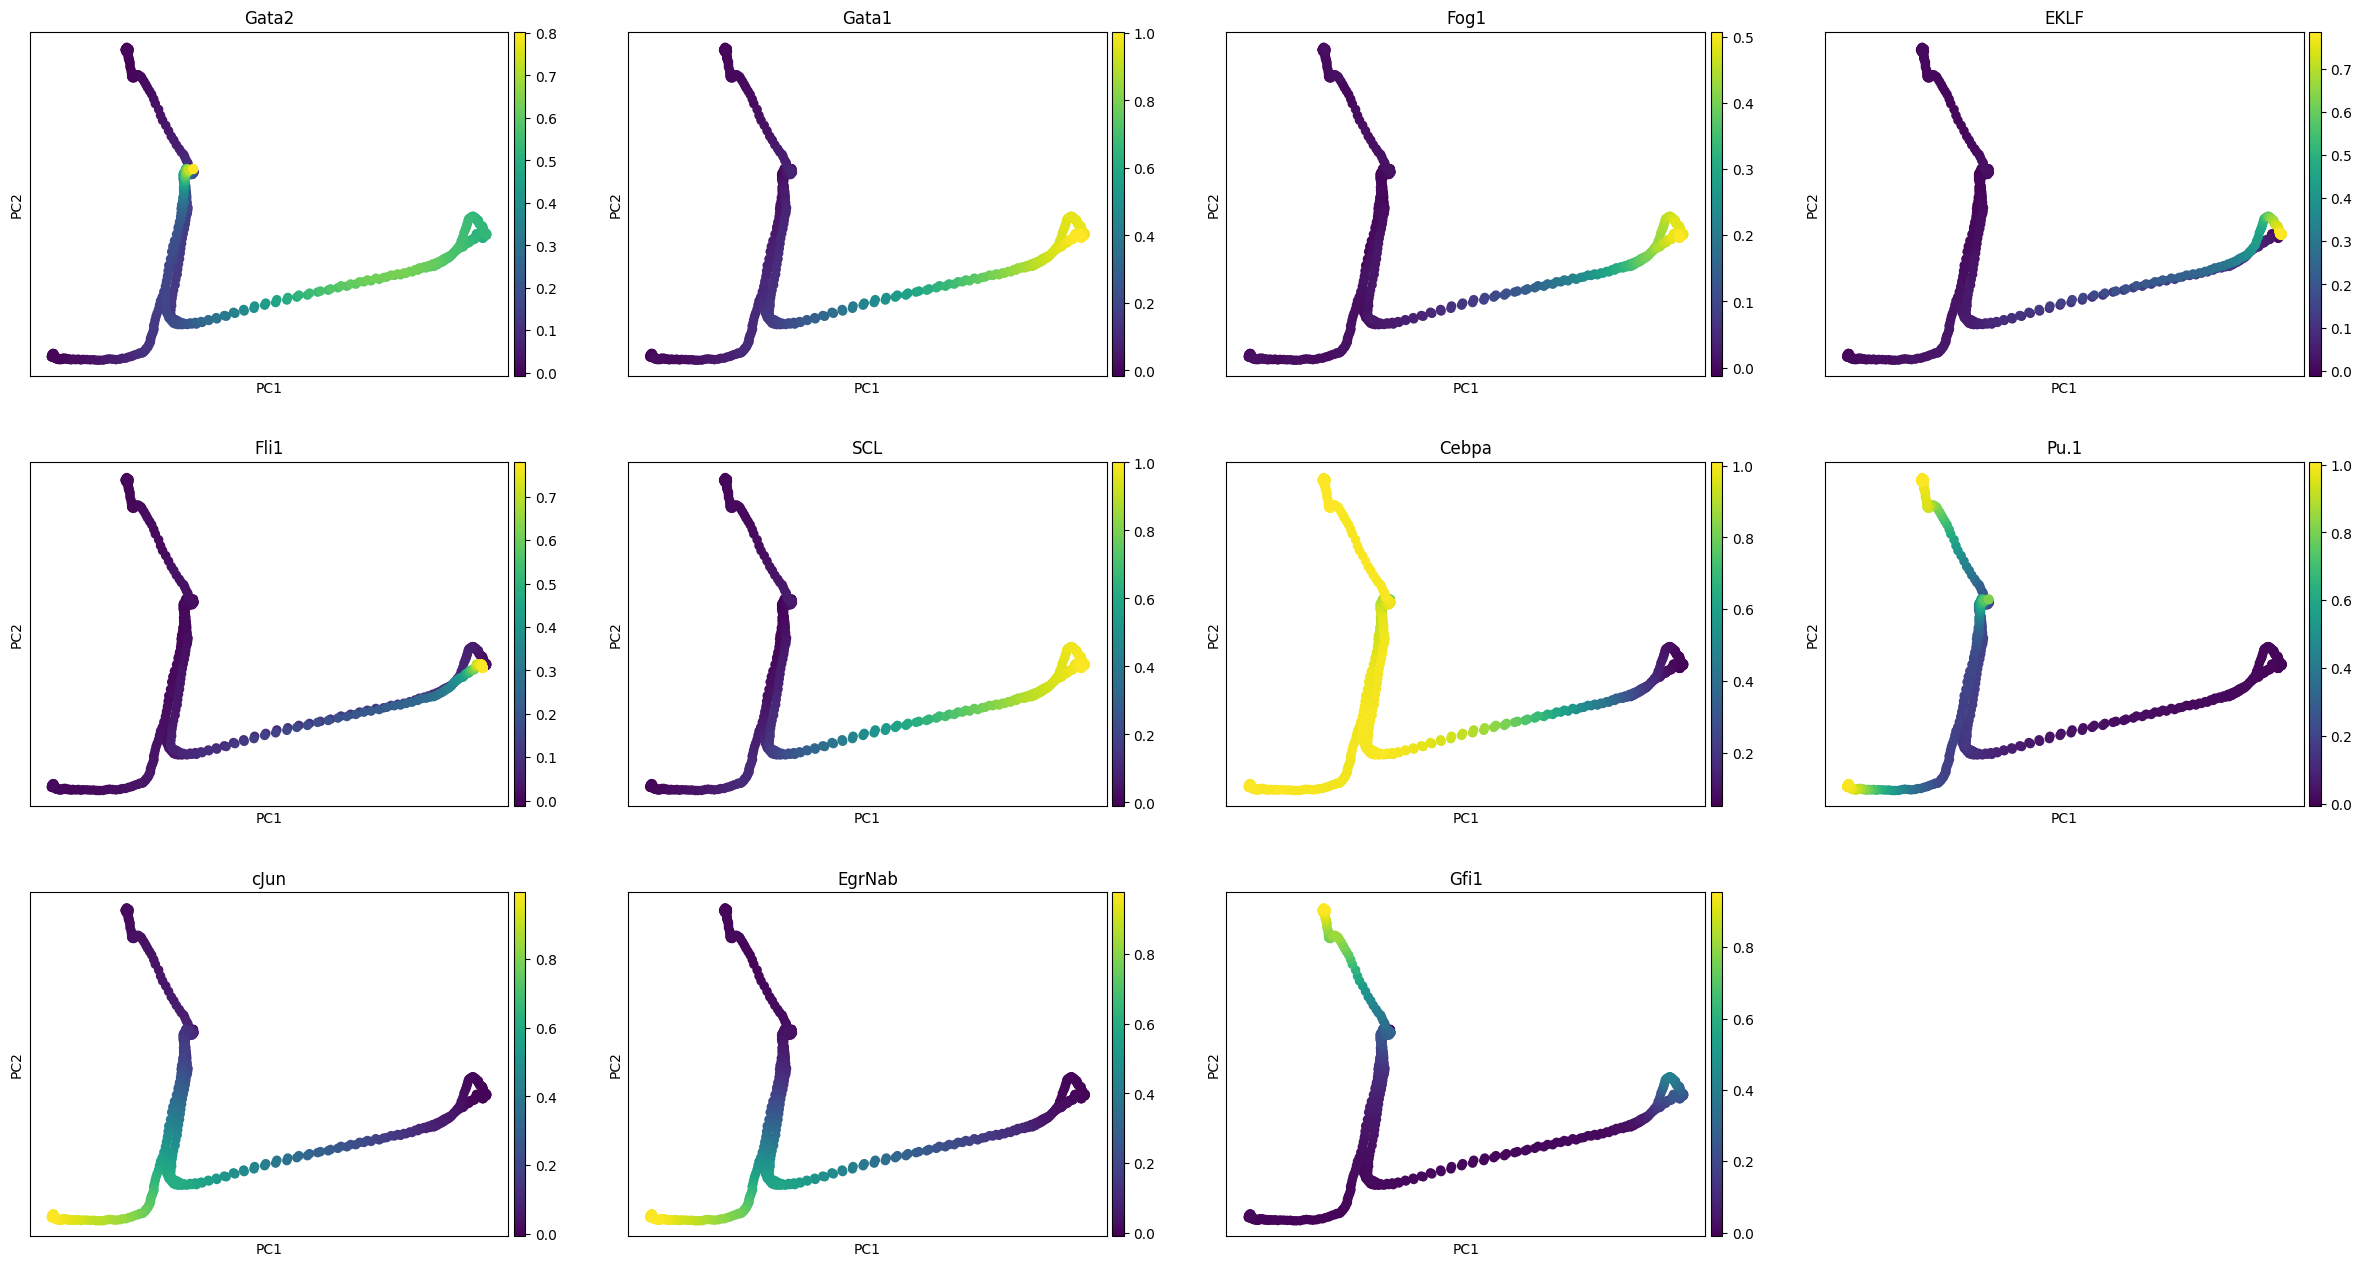

In [ ]:
sc.pl.pca(krum_data, color=list(krum_data.var_names))

# Use this information to create ad-hoc marker genes
krum_data.var["Mo_genes"] = [False, False, False, False, False, False, True, True, True, True, False]
krum_data.var["Ery_genes"] = [True, True, True, True, False, True, False, False, False, False, False]
krum_data.var["Mk_genes"] = [True, True, True, False, True, True, False, False, False, False, False]
krum_data.var["Neu_genes"] = [False, False, False, False, False, False, True, True, False, False, True]

(<Figure size 2000x500 with 4 Axes>,
 <Axes: title={'center': 'Strong Product (Between Cells)'}, xlabel='Colored by Mo_genes'>)

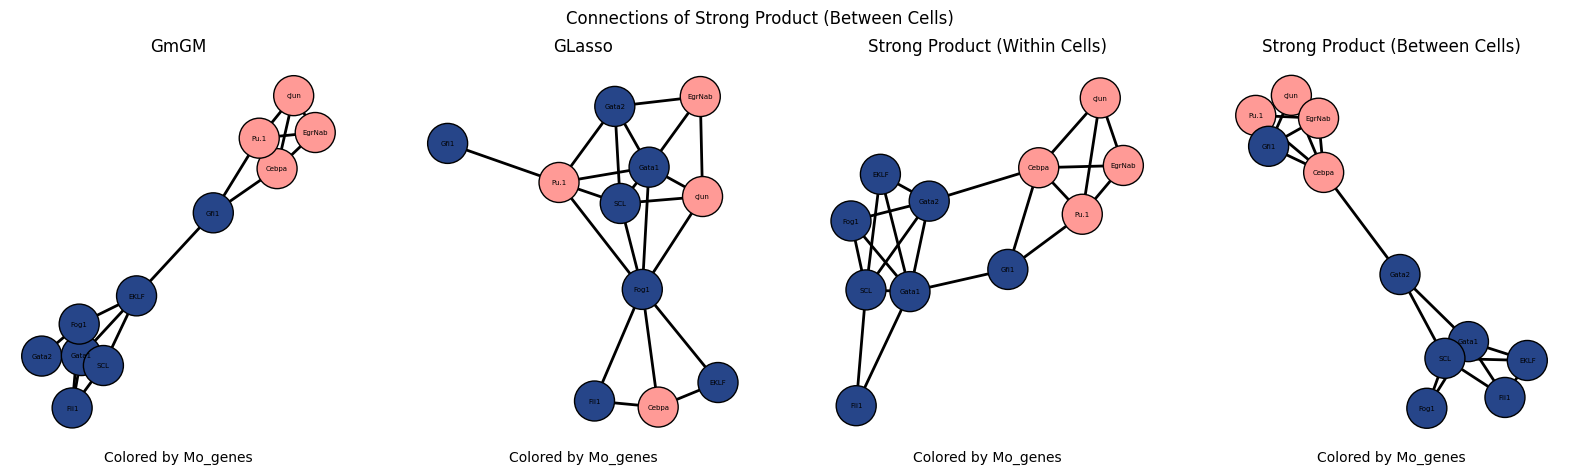

In [93]:
fig, axs = plt.subplots(figsize=(20, 5), ncols=4)
plot_info(
   "GmGM",
   krum_data,
   layout='fr',
   graph_type='var_gmgm_connectivities',
   ax=axs[0],
   fig=fig,
   color_type='Mo_genes'
)
plot_info(
   "GLasso",
   krum_data,
   layout='fr',
   graph_type='var_glasso_connectivities',
   ax=axs[1],
   fig=fig,
   color_type='Mo_genes'
)
plot_info(
   "Strong Product (Within Cells)",
   krum_data,
   layout='fr',
   graph_type='var_sp_within_connectivities',
   ax=axs[2],
   fig=fig,
   color_type='Mo_genes'
)
plot_info(
   "Strong Product (Between Cells)",
   krum_data,
   layout='fr',
   graph_type='var_sp_between_connectivities',
   ax=axs[3],
   fig=fig,
   color_type='Mo_genes'
)

(<Figure size 2000x500 with 4 Axes>,
 <Axes: title={'center': 'Strong Product (Between Cells)'}, xlabel='Colored by Ery_genes'>)

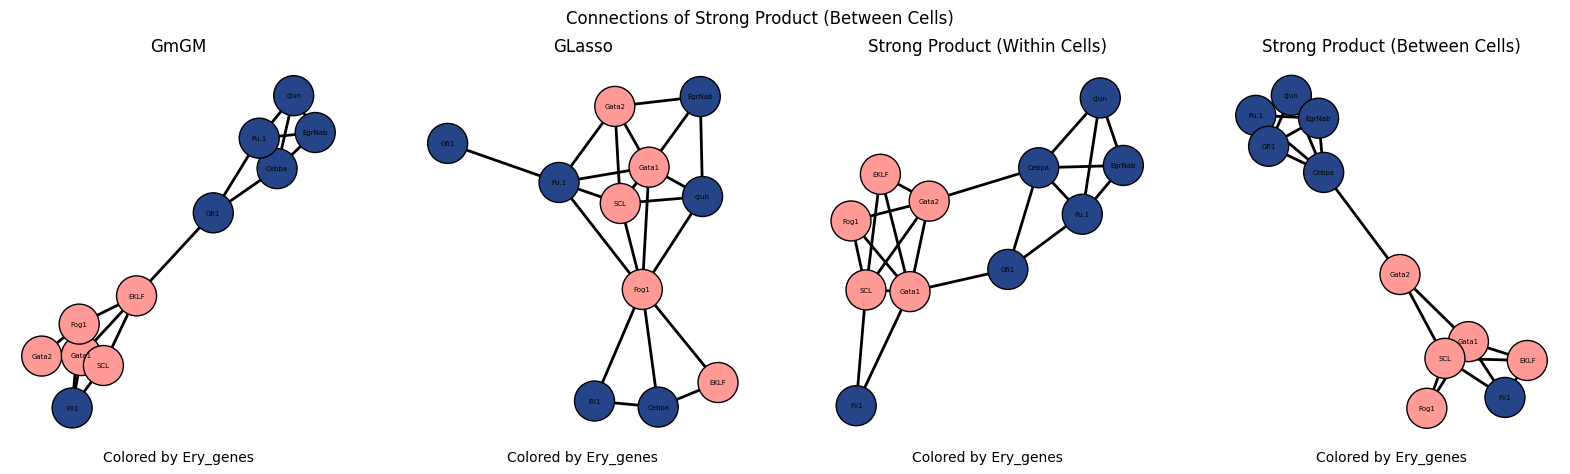

In [95]:
fig, axs = plt.subplots(figsize=(20, 5), ncols=4)
plot_info(
   "GmGM",
   krum_data,
   layout='fr',
   graph_type='var_gmgm_connectivities',
   ax=axs[0],
   fig=fig,
   color_type='Ery_genes'
)
plot_info(
   "GLasso",
   krum_data,
   layout='fr',
   graph_type='var_glasso_connectivities',
   ax=axs[1],
   fig=fig,
   color_type='Ery_genes'
)
plot_info(
   "Strong Product (Within Cells)",
   krum_data,
   layout='fr',
   graph_type='var_sp_within_connectivities',
   ax=axs[2],
   fig=fig,
   color_type='Ery_genes'
)
plot_info(
   "Strong Product (Between Cells)",
   krum_data,
   layout='fr',
   graph_type='var_sp_between_connectivities',
   ax=axs[3],
   fig=fig,
   color_type='Ery_genes'
)

(<Figure size 2000x500 with 4 Axes>,
 <Axes: title={'center': 'Strong Product (Between Cells)'}, xlabel='Colored by Mk_genes'>)

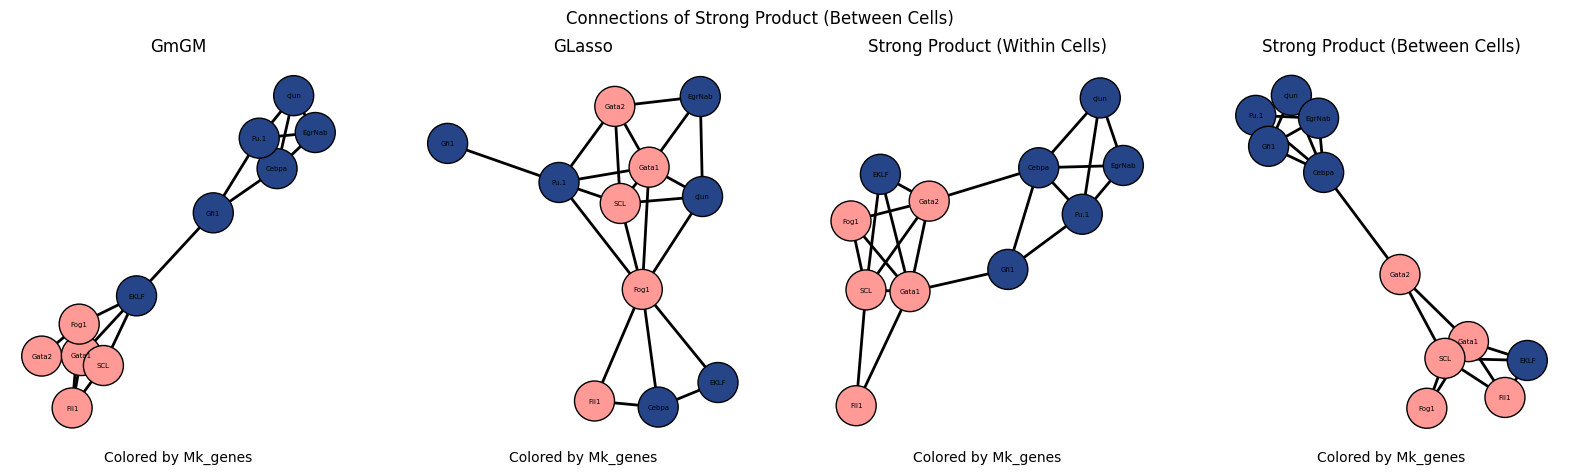

In [96]:
fig, axs = plt.subplots(figsize=(20, 5), ncols=4)
plot_info(
   "GmGM",
   krum_data,
   layout='fr',
   graph_type='var_gmgm_connectivities',
   ax=axs[0],
   fig=fig,
   color_type='Mk_genes'
)
plot_info(
   "GLasso",
   krum_data,
   layout='fr',
   graph_type='var_glasso_connectivities',
   ax=axs[1],
   fig=fig,
   color_type='Mk_genes'
)
plot_info(
   "Strong Product (Within Cells)",
   krum_data,
   layout='fr',
   graph_type='var_sp_within_connectivities',
   ax=axs[2],
   fig=fig,
   color_type='Mk_genes'
)
plot_info(
   "Strong Product (Between Cells)",
   krum_data,
   layout='fr',
   graph_type='var_sp_between_connectivities',
   ax=axs[3],
   fig=fig,
   color_type='Mk_genes'
)

(<Figure size 2000x500 with 4 Axes>,
 <Axes: title={'center': 'Strong Product (Between Cells)'}, xlabel='Colored by Neu_genes'>)

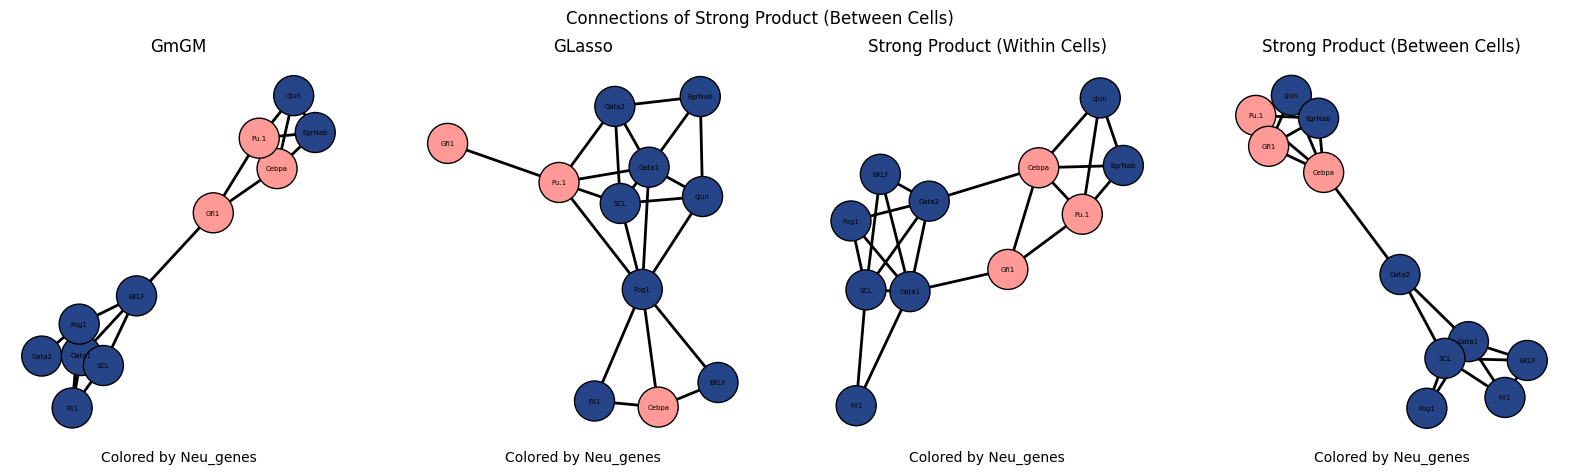

In [97]:
fig, axs = plt.subplots(figsize=(20, 5), ncols=4)
plot_info(
   "GmGM",
   krum_data,
   layout='fr',
   graph_type='var_gmgm_connectivities',
   ax=axs[0],
   fig=fig,
   color_type='Neu_genes'
)
plot_info(
   "GLasso",
   krum_data,
   layout='fr',
   graph_type='var_glasso_connectivities',
   ax=axs[1],
   fig=fig,
   color_type='Neu_genes'
)
plot_info(
   "Strong Product (Within Cells)",
   krum_data,
   layout='fr',
   graph_type='var_sp_within_connectivities',
   ax=axs[2],
   fig=fig,
   color_type='Neu_genes'
)
plot_info(
   "Strong Product (Between Cells)",
   krum_data,
   layout='fr',
   graph_type='var_sp_between_connectivities',
   ax=axs[3],
   fig=fig,
   color_type='Neu_genes'
)